In [317]:
from casadi import *
import numpy as np
from casadi.tools import *
import sympy as sp
import timeit
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib notebook
alpha = SX.sym('a')
theta = SX.sym('t')
phi = SX.sym('p')

dalpha = SX.sym('da')
dtheta = SX.sym('dt')
dphi = SX.sym('dp')


In [318]:
Matrix = np.array
d,l1,l2 = 0.0838,0.2,0.22
d1,d21,d22,d3 = 0.0,d - 0.022327,0.027326,0.13197
mass = np.array([0.696, 1.013, 0.172],dtype = float)
gravity_vector = np.array([0,0,9.8],dtype = float).T



J_num =Matrix([Matrix([
    [-d1*sin(alpha), 0, 0],
    [                0, 0, 0],
    [-d1*cos(alpha), 0, 0]]),
    Matrix([
    [-d21*sin(alpha) - d22*cos(alpha)*cos(theta), d22*sin(alpha)*sin(theta), 0],
    [                                                   0,              -d22*cos(theta), 0],
    [-d21*cos(alpha) + d22*sin(alpha)*cos(theta), d22*sin(theta)*cos(alpha), 0]]),
    Matrix([
    [-d*sin(alpha) - d3*cos(phi + theta)*cos(alpha) - l1*cos(alpha)*cos(theta), d3*sin(phi + theta)*sin(alpha) + l1*sin(alpha)*sin(theta), d3*sin(phi + theta)*sin(alpha)],
    [                                                                                          0,                            -d3*cos(phi + theta) - l1*cos(theta),              -d3*cos(phi + theta)],
    [-d*cos(alpha) + d3*sin(alpha)*cos(phi + theta) + l1*sin(alpha)*cos(theta), d3*sin(phi + theta)*cos(alpha) + l1*sin(theta)*cos(alpha), d3*sin(phi + theta)*cos(alpha)]])]
           )

dJ_num = [Matrix([
         [-d1*cos(alpha)*dalpha, 0, 0],
         [                                        0, 0, 0],
         [ d1*sin(alpha)*dalpha, 0, 0]]),
         Matrix([
         [-d21*cos(alpha)*dalpha + d22*sin(alpha)*cos(theta)*dalpha + d22*sin(theta)*cos(alpha)*dtheta,  d22*sin(alpha)*cos(theta)*dtheta + d22*sin(theta)*cos(alpha)*dalpha, 0],
         [                                                                                                                                                             0,                                                                          d22*sin(theta)*dtheta, 0],
         [ d21*sin(alpha)*dalpha - d22*sin(alpha)*sin(theta)*dtheta + d22*cos(alpha)*cos(theta)*dalpha, -d22*sin(alpha)*sin(theta)*dalpha + d22*cos(alpha)*cos(theta)*dtheta, 0]]),
         Matrix([
         [-d*cos(alpha)*dalpha + d3*(dphi + dtheta)*sin(phi + theta)*cos(alpha) + d3*sin(alpha)*cos(phi + theta)*dalpha + l1*sin(alpha)*cos(theta)*dalpha + l1*sin(theta)*cos(alpha)*dtheta, d3*(dphi + dtheta)*sin(alpha)*cos(phi + theta) + d3*sin(phi + theta)*cos(alpha)*dalpha + l1*sin(alpha)*cos(theta)*dtheta + l1*sin(theta)*cos(alpha)*dalpha, d3*(dphi + dtheta)*sin(alpha)*cos(phi + theta) + d3*sin(phi + theta)*cos(alpha)*dalpha],
         [                                                                                                                                                                                                                                                                                                                       0,                                                                                                                                                        d3*(dphi + dtheta)*sin(phi + theta) + l1*sin(theta)*dtheta,                                                                                 d3*(dphi + dtheta)*sin(phi + theta)],
         [ d*sin(alpha)*dalpha - d3*(dphi + dtheta)*sin(phi + theta)*sin(alpha) + d3*cos(phi + theta)*cos(alpha)*dalpha - l1*sin(alpha)*sin(theta)*dtheta + l1*cos(alpha)*cos(theta)*dalpha, d3*(dphi + dtheta)*cos(phi + theta)*cos(alpha) - d3*sin(phi + theta)*sin(alpha)*dalpha - l1*sin(alpha)*sin(theta)*dalpha + l1*cos(alpha)*cos(theta)*dtheta, d3*(dphi + dtheta)*cos(phi + theta)*cos(alpha) - d3*sin(phi + theta)*sin(alpha)*dalpha]])]
        

In [319]:

J = [0]*3
for j in range(3):
    Jh =[0]*3
    for i,row in enumerate(J_num[j]):
        
        Jh[i] = horzcat(row[0],row[1],row[2])
    J[j] = vertcat(Jh[0],Jh[1],Jh[2])

dJ = [0]*3
for j in range(3):
    dJh = [0]*3
    for i, row in enumerate(dJ_num[j]):
        dJh[i] = horzcat(row[0],row[1],row[2])
    dJ[j] = vertcat(dJh[0],dJh[1],dJh[2])
    

In [320]:
atp = horzcat(alpha,theta,phi)
datp = horzcat(dalpha,dtheta,dphi)
x = vertcat(atp,datp)

J_final = Function('J',[x[0,:]],J)
dJ_final = Function('dJ',[x[0,:],x[1,:]],dJ)

#J_final = [Function('J',[x[0,:]],J[i]) for i in range(3)]
#dJ_final = [Function('dJ',[x[0,:],x[1,:]],dJ[i]) for i in range(3)]


In [321]:
#%timeit [dJ_final[0](1,2,3,4,5,6),dJ_final[1](1,2,3,4,5,6),dJ_final[2](1,2,3,4,5,6)]
#%timeit dJ_final([1,2,3],[4,5,6])

In [322]:
#J_final([1,2,3])


In [323]:
gravity = SX(gravity_vector)
datp = vertcat(dalpha,dtheta,dphi)
tau = SX.sym('tau',3)


A = SX(3,3)
for i in range(3):
    A += mass[i] * J[i].T @ J[i]

B = SX(3,3)
for i in range(3):
    B += mass[i] * J[i].T @ dJ[i]

C = SX(3,3)
for i in range(3):
    C += mass[i] * J[i].T

rhs = B @ datp + C @ gravity - tau
fun_rhs = Function("rhs",[atp,datp,tau],[solve(-A,rhs)])

In [324]:
#x0_var = np.array([[1,2,3],
#                   [4,5,6]],dtype =float)
#tau_var = np.array([1,1,1],dtype =float)
#%timeit fun_rhs(x0_var[0,:],x0_var[1,:],tau_var)

In [325]:

T = 0.75
N = 15

x = vertcat(atp,datp.T)
ode = vertcat(x[1,:],fun_rhs(x[0,:],x[1,:],tau).T)

dae = {'x':x, 'p':tau.T, 'ode':ode}
intg_options = {'tf': T/N}

intg = integrator('intg','rk',dae,intg_options)

In [326]:

#r = intg(x0= x0_var, p=[0.3,0.4,0.2])
#%timeit intg(x0= x0_var, p=[0.3,0.4,0.2])

## MPC

In [327]:
opti = casadi.Opti()
x = opti.variable(2,3*(N+1))
u = opti.variable(1,3*N)
x0 = opti.parameter(2,3)
xgoal = opti.parameter(2,3*(N+1))


weight = np.array([3,1,0],dtype = float) # ТУУУУУТ ВЕСА ВЕСА ТУУУУУУУТ

opti.minimize(sumsqr(x[0,:] - xgoal[0,:])*weight[0] + sumsqr(x[1,:] - xgoal[1,:])*weight[1] + sumsqr(u)*weight[2])

for k in range(1,N+1):
    opti.subject_to(x[:,k*3 : (k+1)*3] == intg(x0 = x[:,(k-1)*3 : k*3],p = u[:,(k-1)*3 : k*3])['xf'])

for i in range(N):
        opti.subject_to(opti.bounded(-2,u[i*3],1))
        opti.subject_to(opti.bounded(-40,u[i*3 + 1],40))
        opti.subject_to(opti.bounded(-40,u[i*3 + 2],40))

opti.subject_to(x[:,0:3] == x0)

for k in range(1,N+1):
    xyz = lastPoint(x[0,k*3],x[0,k*3 +1],x[0,k*3 +2])
    opti.subject_to(xyz[2] > -0.55 + 0.35 *1/ (1 + (exp((-xyz[1] + 0.1)))**30) )


#Xplot = np.linspace(0,0.5,10)
#Xplot0 = -0.55
#XplotAlpha = 0.35
#Xplot_shift = 0.1
#Yplot = Xplot0 + XplotAlpha * 1/ (1 + (np.exp((-Xplot + Xplot_shift)))**30)



opti_options = {'print_in':False, 'print_out':False, 'print_time':False}
solver_options = {'print_level' : 0}

opti.solver('ipopt',opti_options,solver_options)

In [328]:
x0_var = np.array([[0,0,0],
                   [0,0,0]],dtype =float)
xgoal_var = np.array([[-0.3,0,0]*(N+1),[0,0,0]*(N+1)],dtype = float)
opti.set_value(x0,x0_var)
opti.set_value(xgoal,xgoal_var)
sol = opti.solve()
mpc = opti.to_function("MPC",[x0,xgoal],[u],["x0","xgoal"],["u_opt"])
mpc

Function(MPC:(x0[2x3],xgoal[2x48])->(u_opt[1x45]) MXFunction)

## Преобразователь для уголы -> xyz

In [329]:
px = SX.sym('px')
py = SX.sym('py')
pz = SX.sym('pz')
angel = SX.sym('angel')
T = SX(4,4)
Ux = SX(4,4)
Uy = SX(4,4)
Uz = SX(4,4)

T[:,:] = np.array([[1,0,0,px],
                       [0,1,0,py],
                       [0,0,1,pz],
                       [0,0,0,1]])
Ux[:,:] = np.array([[1,0,0,0]
                      ,[0,cos(angel),-sin(angel),0]
                      ,[0,sin(angel),cos(angel),0]
                      ,[0,0,0,1]])
Uy[:,:] = np.array([[cos(angel),0,sin(angel),0]
                          ,[0,1,0,0]
                          ,[-sin(angel),0,cos(angel),0]
                          ,[0,0,0,1]])
Uz[:,:] = np.array([[cos(angel),-sin(angel),0,0]
                          ,[sin(angel),cos(angel),0,0]
                          ,[0,0,1,0]
                          ,[0,0,0,1]])
Uy = Function('Uy',[angel],[Uy])
Ux = Function('Ux',[angel],[Ux])
T = Function('T',[px,py,pz],[T])
lastPoint = Function('LastPoint',[alpha,theta,phi],[(Uy(alpha) @ T(d,0,0) @ Ux(-theta) @ T(0,0,-l1) @ Ux(-phi) @ T(0,0,-l2))[0:3,-1]])

# Преобразователь для рисовалки + рисовалка

In [330]:
def T(p):
    px,py,pz =p
    return sp.Matrix([[1,0,0,px],
                       [0,1,0,py],
                       [0,0,1,pz],
                       [0,0,0,1]])
def U(ax,angel):
    cos = sp.cos
    sin = sp.sin
    if(ax == sp.Symbol('x')):
        return sp.Matrix([[1,0,0,0]
                      ,[0,cos(angel),-sin(angel),0]
                      ,[0,sin(angel),cos(angel),0]
                      ,[0,0,0,1]])
    if(ax == sp.Symbol('y')):
        return sp.Matrix([[cos(angel),0,sin(angel),0]
                          ,[0,1,0,0]
                          ,[-sin(angel),0,cos(angel),0]
                          ,[0,0,0,1]])
    if(ax == sp.Symbol('z')):
        return sp.Matrix([[cos(angel),-sin(angel),0,0]
                          ,[sin(angel),cos(angel),0,0]
                          ,[0,0,1,0]
                          ,[0,0,0,1]])
    
def SUM(mat):
    res = sp.zeros(mat[0].shape[0],mat[0].shape[1])
    for vec in mat:
        res += vec
    return res


t = sp.Symbol('t')
alpha, theta, phi = sp.Function('alpha')(t),sp.Function('theta')(t),sp.Function('phi')(t)
d, l1, l2 = sp.symbols('d l1 l2')
x,y,z = sp.symbols('x y z')
d1,d21,d22,d3 = sp.symbols('d1 d21 d22 d3')
g, m1,m2,m3 = sp.symbols('g m1 m2 m3')

d_real,l1_real,l2_real = 0.0838,0.2,0.22
d1_real,d21_real,d22_real,d3_real = 0.0,d_real - 0.022327,0.027326,0.13197
subs = [(d,d_real),(l1,l1_real),(l2,l2_real),(d1,d1_real),(d21,d21_real),(d22,d22_real),(d3,d3_real)]
angels = [alpha,theta,phi]

plt_points = [[0,0,0]]*3
plt_points[0] = sp.simplify(U(y,alpha) @ T([d,0,0]))[0:3,-1]
plt_points[1] = sp.simplify(U(y,alpha) @ T([d,0,0]) @ U(x,-theta) @ T([0,0,-l1]))[0:3,-1]
plt_points[2] = sp.simplify(U(y,alpha) @ T([d,0,0]) @ U(x,-theta) @ T([0,0,-l1]) @ U(x,-phi) @ T([0,0,-l2]))[0:3,-1]
plt_points = [plt_points[i].subs(subs) for i in range(3)]
plt_points = [sp.lambdify((angels), plt_points[i], modules='numpy') for i in range(3)]

def ppplot_seq(my_angels,final_point,color = 'red',myalpha= 1,color2  = 'blue', myalpha2 = 0.3):
    print(my_angels)
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    ax.set_xlim3d(0, 1/2)
    ax.set_ylim3d(0, 1/2)
    ax.set_zlim3d(-1/2, 0)
    
    dy = 0.06
    
    for j in range(len(my_angels)):
        a,t,p =my_angels[j]
        ap,tp,pp = final_point[j]
        
        x0,y0,z0 = 0,0,0
        x,y,z = plt_points[2](ap,tp,pp) 
        ax.scatter(x,y + dy*j,z,c=color2,alpha = myalpha2)
        for i in range(3):
            x,y,z = plt_points[i](a,t,p) 
            ax.scatter(x,y + dy*j,z,c=color,alpha = myalpha)
            ax.plot([x0,x],[y0+ dy*j,y+ dy*j],[z0,z],c=color,alpha = myalpha)
            x0,y0,z0 = x[0],y[0],z[0]

# Тестовая камера

In [331]:

x0_calc = np.array([[0,0,0],
                        [0,0,0]],dtype = float)
x_calc_goal = np.array([[0.07662218741679261, -0.147144509205183, -1.9720016170266235]*(N+1),
                        [0,0,0]*(N+1)])

NumSteps = 30
X_story = [0]*NumSteps
X_real =[0]*NumSteps
#Y_story = [0]*NumSteps

X_story[0] = x0_calc
X_real[0] = x0_calc
for i in range(1,NumSteps):
    
    u = mpc(x0_calc,x_calc_goal).full()
    u =u[0][0:3]
    
    
    
    x0_calc = intg(x0 = x0_calc,p = u)['xf'].full()
    X_story[i] = np.array(x0_calc)

    x0_calc += np.random.normal(0, .0002, (2,3))

    X_real[i] = np.array(x0_calc)

# Анализируем резы

In [336]:
#ppplot(X_story)
angels_real_story = [X_real[i][0,:] for i in range(len(X_real))]
angels_approx_story = [X_story[i][0,:] for i in range(len(X_story))]
#ppplot_seq(angels_real_story,angels_approx_story)


In [342]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
def plot_cube(ax,cube_definition):
    cube_definition_array = [
        np.array(list(item))
        for item in cube_definition
    ]

    points = []
    points += cube_definition_array
    vectors = [
        cube_definition_array[1] - cube_definition_array[0],
        cube_definition_array[2] - cube_definition_array[0],
        cube_definition_array[3] - cube_definition_array[0]
    ]

    points += [cube_definition_array[0] + vectors[0] + vectors[1]]
    points += [cube_definition_array[0] + vectors[0] + vectors[2]]
    points += [cube_definition_array[0] + vectors[1] + vectors[2]]
    points += [cube_definition_array[0] + vectors[0] + vectors[1] + vectors[2]]

    points = np.array(points)

    edges = [
        [points[0], points[3], points[5], points[1]],
        [points[1], points[5], points[7], points[4]],
        [points[4], points[2], points[6], points[7]],
        [points[2], points[6], points[3], points[0]],
        [points[0], points[2], points[4], points[1]],
        [points[3], points[6], points[7], points[5]]
    ]

    
    ax 

    faces = Poly3DCollection(edges, linewidths=1, edgecolors='k')
    faces.set_facecolor((0,0,1,0.1))

    ax.add_collection3d(faces)

    # Plot the points themselves to force the scaling of the axes
    ax.scatter(points[:,0], points[:,1], points[:,2], s=0)
    return ax

cube_definition = [
    (0,0,0), (0,1,0), (1,0,0), (0,0,1)
]
#plot_cube(plt.figure(),cube_definition)



class forAnimation():
    
    def __init__(self,fig,my_angels,final_point,goal_point):
        self.my_angels = my_angels
        self.final_point = final_point
        self.goal_point =goal_point
        self.fig = fig
        ax = fig.add_subplot(projection='3d')
        self.ax = ax

    
    def reset(self):
        ax = self.ax
        ax.clear()
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')

        ax.set_xlim3d(0, 1/2)
        ax.set_ylim3d(0, 1/2)
        ax.set_zlim3d(-1/2, 0)
    
    def ppplot_animate(self,j):
        color = 'red'
        myalpha= 1
        color2  = 'blue'
        myalpha2 = 0.3
        ax = self.ax
        self.reset()
        dy = 0

        a,t,p = self.my_angels[j]
        ap,tp,pp = self.final_point[j]
        ag,tg,pg = self.goal_point
        
        x0,y0,z0 = 0,0,0
        x,y,z = plt_points[2](ap,tp,pp) 
        res = ax.scatter(x,y + dy*j,z,c=color2,alpha = myalpha2)
        
        x,y,z = plt_points[2](ag,tg,pg) 
        res = ax.scatter(x,y + dy*j,z,c='black',alpha = 1)
        for i in range(3):
            x,y,z = plt_points[i](a,t,p) 
            ax.scatter(x,y + dy*j,z,c=color,alpha = myalpha)
            res = ax.plot([x0,x],[y0+ dy*j,y+ dy*j],[z0,z],c=color,alpha = myalpha)
            x0,y0,z0 = x[0],y[0],z[0]
        cube_definition = [
        (0,0.2,-0.5), (0,0.5,-0.5), (0.2,0.2,-0.5), (0,0.2,-0.2)
        ]
        #ax.view_init(0, 0)
        res = plot_cube(self.ax,cube_definition)
        
        return res

<IPython.core.display.Javascript object>


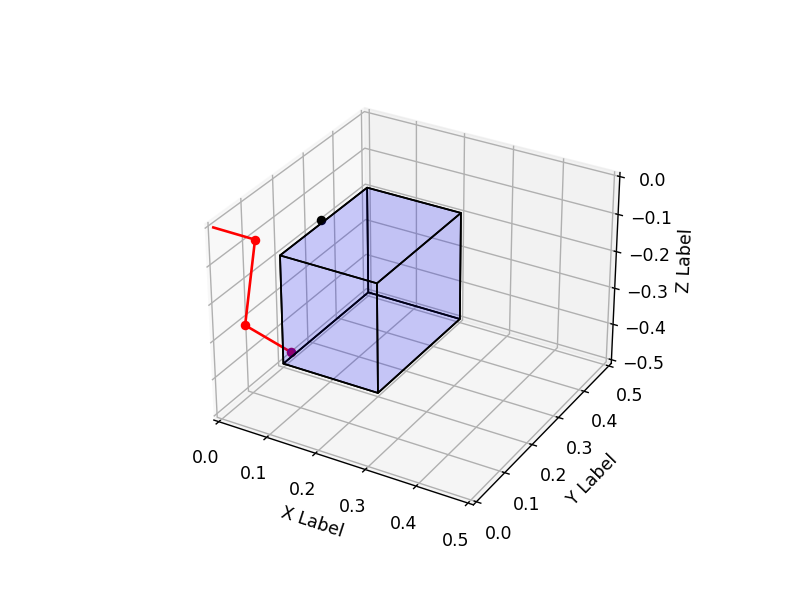

MovieWriter imagemagick unavailable; using Pillow instead.
C:\Users\Slava\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
C:\Users\Slava\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\stride_tricks.py:341: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(array, copy=False, subok=subok)
C:\Users\Slava\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecation

In [343]:
fig = plt.figure()
animator =forAnimation(fig,angels_real_story,angels_approx_story,x_calc_goal[0,0:3])
gif = animation.FuncAnimation(fig,animator.ppplot_animate,np.arange(0,NumSteps),interval = 500)
gif.save('test13.gif', writer='imagemagick',   fps=4)

In [ ]:
lastPoint(1,2,3)

In [ ]:
plt_points[2](1,2,3)

In [ ]:
Xplot = np.linspace(0,0.5,10)
Xplot0 = -0.55
XplotAlpha = 0.35
Xplot_shift = 0.1
Yplot = Xplot0 + XplotAlpha * 1/ (1 + (np.exp((-Xplot + Xplot_shift)))**30)



import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim([0,0.5])
ax.set_ylim([-0.5,0])
ax.plot(Xplot,Yplot)

In [ ]:
(-Xplot + Xplot_shift)**7

In [ ]:
1/ (1 + np.exp((-Xplot + Xplot_shift)**7))

In [ ]:
ppp <aaa

In [ ]:
MX

In [ ]:
A = 2
d =1/2
T = 1
t = np.linspace(0,10,1000)

XXXX = sum([2*A*d* np.sin(np.pi * n*d)/ (np.pi * n*d) *np.cos(n * 2* np.pi /T * t) for n in range(1,10)])

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(t,XXXX)